In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="MIG-e23853d6-1ca4-59e9-ac9a-1887267908f3" 
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
device = "cuda:0"

In [3]:
# Set paths
os.chdir("/allen/aics/modeling/ritvik/projects/benchmarking_representations/")
save_path = "./test_cellpack_recons/"

In [4]:
# norms used for viz
cellpack_data = "./configs/data/cellpack/pc.yaml"
with open(cellpack_data) as stream:
    cellpack_data = yaml.safe_load(stream)

In [5]:
data = instantiate(cellpack_data)


In [6]:
batch = next(iter(data.test_dataloader()))

get_packings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 37.37it/s]


In [41]:
batch['orig_CellId']

['9c1ff213-4e9e-4b73-a942-3baf9d37a50f',
 '9c1ff213-4e9e-4b73-a942-3baf9d37a50f',
 '9c1ff213-4e9e-4b73-a942-3baf9d37a50f',
 '9c1ff213-4e9e-4b73-a942-3baf9d37a50f',
 '9c1ff213-4e9e-4b73-a942-3baf9d37a50f',
 '9c1ff213-4e9e-4b73-a942-3baf9d37a50f']

In [15]:
batch.keys()

dict_keys(['pcloud', 'shcoeff', 'orig_CellId_int', 'orig_CellId', 'rule', 'cell_id', 'packing_rotation', 'rotation_aug', 'jitter_aug', 'nuc_vol', 'nuc_height', 'nuc_area', 'nuc_vol2', 'nuc_vol_bin', 'rule_one_hot', 'structure'])

In [39]:
from pathlib import Path
this_save_path = Path(save_path) / Path("panel_a")
this_save_path.mkdir(parents=True, exist_ok=True)

all_arr = []
for i in range(6):
    np_arr = batch['pcloud'][i].numpy()
    new_array = np.zeros(np_arr.shape)
    z = np_arr[:, 0]
    # inds = np.where(z > 0.1)[0]
    new_array[:,0] = np_arr[:, 2]
    new_array[:,1] = z
    new_array[:,2] = np_arr[:, 1]
    new_array = new_array[inds]
    all_arr.append(new_array)
    np.save(this_save_path / Path(f"{i}.npy"), new_array)

In [40]:
all_arr[2].min(axis=0)

array([-7.68686295, -1.29767382, -5.10626793])

In [8]:
batch['pcloud'].shape

torch.Size([6, 2048, 3])

In [43]:
import pandas as pd
gg = pd.read_csv('/allen/aics/modeling/ritvik/forSaurabh/manifest.csv')

In [49]:
path = gg.loc[gg['CellId'] == '9c1ff213-4e9e-4b73-a942-3baf9d37a50f']['nucobj_path'].iloc[0]

In [58]:
this_save_path

PosixPath('test_cellpack_recons/panel_a')

In [101]:
%load_ext autoreload
%autoreload 2

mi.set_variant('scalar_rgb')
import os
import numpy as np
import matplotlib.pyplot as plt
import mitsuba as mi
from mitsuba import ScalarTransform4f as T

import trimesh
from trimesh.transformations import rotation_matrix


import trimesh

def plot(this_mesh_path, angle, angle2=None, angle3=None, name=None):
    myMesh = trimesh.load(this_mesh_path)
    
    # Scale the mesh to approximately one unit based on the height
    sf = 1.
    myMesh.apply_scale(sf/myMesh.extents.max())
    
    # for 3_1
    myMesh = myMesh.apply_transform(rotation_matrix(np.deg2rad(angle), [0,0,-1]))
    if angle2:
        myMesh = myMesh.apply_transform(rotation_matrix(np.deg2rad(angle2), [0,1,0]))

    if angle3:
        myMesh = myMesh.apply_transform(rotation_matrix(np.deg2rad(angle3), [1,0,0]))
    # myMesh = myMesh.apply_transform(rotation_matrix(np.deg2rad(0), [1,0,0]))
    
    # Translate the mesh so that it's centroid is at the origin and rests on the ground plane
    myMesh.apply_translation([-myMesh.bounds[0,0] - myMesh.extents[0] / 2.0,
                              -myMesh.bounds[0,1] - myMesh.extents[1] / 2.0,
                              -myMesh.bounds[0,2]])
    
    # Fix the mesh normals for the mesh
    myMesh.fix_normals()
    
    # Write the mesh to an external file (Wavefront .obj)
    with open('mesh.obj', 'w') as f:
        f.write(trimesh.exchange.export.export_obj(myMesh,include_normals=True ))
    
    #Create a sensor that is used for rendering the scene
    def load_sensor(r, phi, theta):
        # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
        origin = T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, r])
    
        return mi.load_dict({
            'type': 'perspective',
            'fov': 15.0,
            'to_world': T.look_at(
                origin=origin,
                target=[0, 0, myMesh.extents[2]/2],
                up=[0, 0, 1]
            ),
            'sampler': {
                'type': 'independent',
                'sample_count': 16
            },
            'film': {
                'type': 'hdrfilm',
                'width': 1024,
                'height': 768,
                'rfilter': {
                    'type': 'tent',
                },
                'pixel_format': 'rgb',
            },
        })
    
    # Scene parameters
    relativeLightHeight = 8
    
    # A scene dictionary contains the description of the rendering scene.
    scene2 = mi.load_dict({
        'type': 'scene',
        # The keys below correspond to object IDs and can be chosen arbitrarily
        'integrator': {'type': 'path'},
    
        'mesh': {
            'type': 'obj',
            'filename': 'mesh.obj',
            'face_normals': True, # This prevents smoothing of sharp-corners by discarding surface-normals. Useful for engineering CAD.
            'bsdf': {
                # 'type': 'diffuse',
                # 'reflectance': {
                #     'type': 'rgb',
                #     'value': [0.1, 0.27, 0.86]
                # }
            # 'type': 'plastic',
            # 'diffuse_reflectance': {
            #     'type': 'rgb',
            #     'value': [0.1, 0.27, 0.36]
            # },
            # 'int_ior': 1.9
                # 'type': 'roughplastic'
                'type': 'pplastic',
                'diffuse_reflectance': {
                    'type': 'rgb',
                    'value': [0.05, 0.03, 0.1]
                },
                'alpha': 0.02
            }
        },
    
        # A general emitter is used for illuminating the entire scene (renders the background white)
        'light': {'type': 'constant', 'radiance': 1.0},
        'areaLight': {
            'type': 'rectangle',
            # The height of the light can be adjusted below
            'to_world': T.translate([0,0.0,myMesh.bounds[1,2] + relativeLightHeight]).scale(1.0).rotate([1,0,0], 5.0),
            'flip_normals': True,
            'emitter': {
                'type': 'area',
                'radiance': {
                    'type': 'spectrum',
                    'value': 30.0,
                }
            }
        },
    
        'floor': {
            'type': 'disk',
            'to_world': T.scale(3).translate([0.0,0.0,0.0]),
            'material': {
                'type': 'diffuse',
                'reflectance': {'type': 'rgb', 'value': 0.75},
            }
        }
    })
    
    sensor_count = 1
    
    radius = 4
    phis = [130.0]
    theta = 60.0
    
    sensors = [load_sensor(radius, phi, theta) for phi in phis]
    
    """
    Render the Scene
    The render samples are specified in spp
    """
    image = mi.render(scene2, sensor=sensors[0], spp=256)
    
    # Write the output
    
    save_path = this_save_path
    mi.util.write_bitmap(str(save_path) + f"{name}.png", image)
    # mi.util.write_bitmap(save_path + ".exr", image)
    
    # Display the output in an Image
    plt.imshow(image** (1.0 / 2.2))
    plt.axis('off')
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
path

'/allen/aics/modeling/ritvik/forSaurabh/9c1ff213-4e9e-4b73-a942-3baf9d37a50f_0.obj'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15936759..1.1262691].


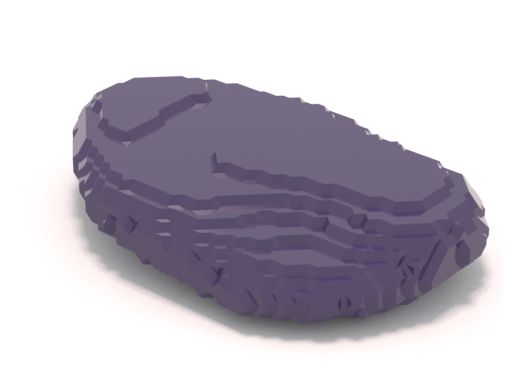

In [103]:
plot(path, 0, 90, 0, 'nuc')

In [104]:
aa = np.load('/allen/aics/modeling/ritvik/projects/benchmarking_representations/viz_pcna_pointclouds/midS-lateS_c6b66235-554c-4fd3-b0a2-a1e5468afb64.npy')

In [107]:
aa.max(axis=0)

array([7.90003714, 6.60004688, 0.69999917, 1.        , 1.        ,
       0.85098039])

In [108]:
bb = np.load('/allen/aics/modeling/ritvik/projects/benchmarking_representations/notebooks_old/variance_all_punctate/pcna/latent_walks/viz/midS-lateS_0_1.npy')

In [109]:
bb.max(axis=0)

array([7.323581  , 5.8398848 , 0.2943992 , 0.95792388, 0.98363706,
       0.76838139])

In [111]:
aa = np.load('/allen/aics/modeling/ritvik/projects/benchmarking_representations/viz_variance_pointclouds2/NUP153_692417.npy')

In [112]:
aa.max(axis=0)

array([5.59997795, 5.40004714, 1.09999929, 1.        , 1.        ,
       0.85098039])

In [119]:
bb = np.load('/allen/aics/modeling/ritvik/projects/benchmarking_representations/test_var_punctate_embeddings/latent_walks/structure_name_NUP153_0_0.npy')

In [120]:
bb.max(axis=0)

array([5.2694244 , 4.604405  , 0.19583076, 0.9867128 , 0.99483276,
       0.82145329])